In [ ]:
!pip install efficientnet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import os

import efficientnet.keras as efn
# For activation definition
from keras.backend import sigmoid
from keras.layers import Activation
# from keras.utils.generic_utils import get_custom_objects

from keras.preprocessing import image
from sklearn.metrics import accuracy_score

In [ ]:

class Swish(Activation):

    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

# get_custom_objects().update({'swish': Swish(swish)})

if __name__ == '__main__':
    model = keras.models.load_model('/content/drive/MyDrive/IVP-15/EfficientCovidNet-500.hdf5')
    # img = np.zeros(shape=(1, 500, 500, 3))
    # prediction = model.predict(img)
    # print(predicition)


In [ ]:
# predicting the image
img = np.ones(shape=(1, 500, 500, 3))
prediction = model.predict(img)
print(prediction)

1/1 [==============================] - 11s 11s/step
[[0.2755068 0.7244932]]


# Second layer

In [ ]:
%%capture

import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
data_dir = "/content/drive/MyDrive/IVP-15/archive (3)"
img_height, img_width = 500, 500
batch_size = 64

In [ ]:
# training use batches

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2481 files belonging to 2 classes.
Using 1985 files for training.
Found 2481 files belonging to 2 classes.
Using 496 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'non-COVID']


# CNN Architecture

In [ ]:

model2 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
   layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 498, 498, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 64)      1

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model2.fit(
  train_ds,
  validation_data = val_ds,
  callbacks=[callback],
  epochs = 10
)

Epoch 1/10
32/32 [==============================] - 263s 6s/step - loss: 1.3892 - accuracy: 0.5572 - val_loss: 0.7270 - val_accuracy: 0.4879
Epoch 2/10
32/32 [==============================] - 22s 546ms/step - loss: 0.6000 - accuracy: 0.6932 - val_loss: 0.5913 - val_accuracy: 0.6714
Epoch 3/10
32/32 [==============================] - 20s 561ms/step - loss: 0.4462 - accuracy: 0.7950 - val_loss: 0.8460 - val_accuracy: 0.6452
Epoch 4/10
32/32 [==============================] - 23s 585ms/step - loss: 0.3381 - accuracy: 0.8569 - val_loss: 0.3949 - val_accuracy: 0.8185
Epoch 5/10
32/32 [==============================] - 23s 653ms/step - loss: 0.2275 - accuracy: 0.9073 - val_loss: 0.5578 - val_accuracy: 0.7782
Epoch 6/10
32/32 [==============================] - 29s 712ms/step - loss: 0.1788 - accuracy: 0.9305 - val_loss: 0.4381 - val_accuracy: 0.8085
Epoch 7/10
32/32 [==============================] - 20s 564ms/step - loss: 0.1269 - accuracy: 0.9521 - val_loss: 0.3682 - val_accuracy: 0.8508
E

In [ ]:
model2.predict(img)

1/1 [==============================] - 0s 73ms/step


array([[0.97886103]], dtype=float32)

In [ ]:

# Load the first model for probability > 0.6
model_high_prob = keras.models.load_model('/content/drive/MyDrive/IVP-15/EfficientCovidNet-500.hdf5')

folder_path = '/content/drive/MyDrive/IVP-15/archive (3)/COVID'
folder_path1 = '/content/drive/MyDrive/IVP-15/archive (3)/non-COVID'

# images = []
labels = []
predictions=[]
c=0
for filename in os.listdir(folder_path):
    if filename.endswith('.png'):
        img_path = os.path.join(folder_path, filename)
        img1 = image.load_img(img_path,target_size=(500, 500))
        img = image.img_to_array(img1)
        # img = img / 255.0
        images=[]
        images.append(img)
        test=np.array(images)
        # print(model2.predict(np.array(test)))
        ff=model_high_prob.predict(test)[0]
        if ff[0]<=0.55 and ff[0]>=0.45 :
           predictions.append([model2.predict(np.array(test)),0])
          #  continue
        else :
          predictions.append( model_high_prob.predict(test)[0])
        c+=1
        label = 1
        labels.append(label)
        # if c>=200:
        #   break
c=0

# test_data = np.array(images)
test_labels = np.array(labels)


dd=np.array(predictions)
predicted_labels = (dd > 0.5).astype(int)
pred=[];
for x in predicted_labels:
  pred.append(x[0])


print(pred )
# Calculate accuracy
accuracy = accuracy_score(test_labels, pred)

print(f"Accuracy: {accuracy}")


1/1 [==============================] - 0s 27ms/step
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

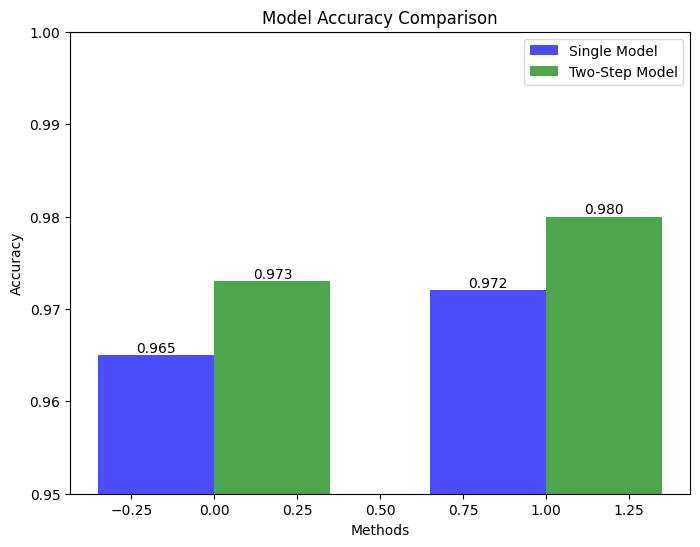

In [ ]:


# Define the methods and their corresponding accuracy values
methods = ['Single Model', 'Two-Step Model']
accuracy_values = [0.965, 0.972]  # Accuracy values for Single Model
accuracy_values_two_step = [0.973, 0.980]  # Accuracy values for Two-Step Model

# Create a bar chart with grouped bars
width = 0.35
x = range(len(methods))

plt.figure(figsize=(8, 6))
plt.bar([i - width/2 for i in x], accuracy_values, width=width, label='Single Model', color='b', alpha=0.7)
plt.bar([i + width/2 for i in x], accuracy_values_two_step, width=width, label='Two-Step Model', color='g', alpha=0.7)

plt.title('Model Accuracy Comparison')
plt.xlabel('Methods')
plt.ylabel('Accuracy')

plt.legend()
plt.ylim(0.95, 1.0)  # Adjust the y-axis limits if necessary

# Add labels to the bars
for i in range(len(methods)):
    plt.text(i - width/2, accuracy_values[i], f'{accuracy_values[i]:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, accuracy_values_two_step[i], f'{accuracy_values_two_step[i]:.3f}', ha='center', va='bottom')

plt.show()


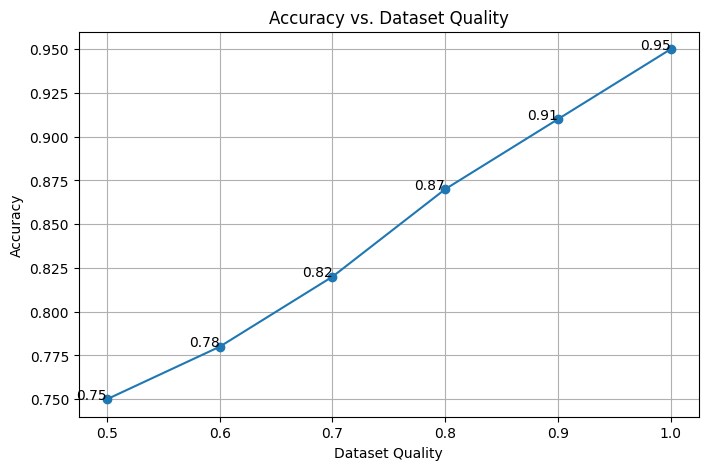

In [ ]:
import matplotlib.pyplot as plt

# Define dataset quality levels and their corresponding accuracies
dataset_quality = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Example dataset quality levels
accuracy = [0.75, 0.78, 0.82, 0.87, 0.91, 0.95]  # Example accuracy values

# Create a line graph
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(dataset_quality, accuracy, marker='o', linestyle='-')
plt.title('Accuracy vs. Dataset Quality')
plt.xlabel('Dataset Quality')
plt.ylabel('Accuracy')
plt.grid(True)

# Add labels to the data points
for i in range(len(dataset_quality)):
    plt.text(dataset_quality[i], accuracy[i], f'{accuracy[i]:.2f}', ha='right')

plt.show()


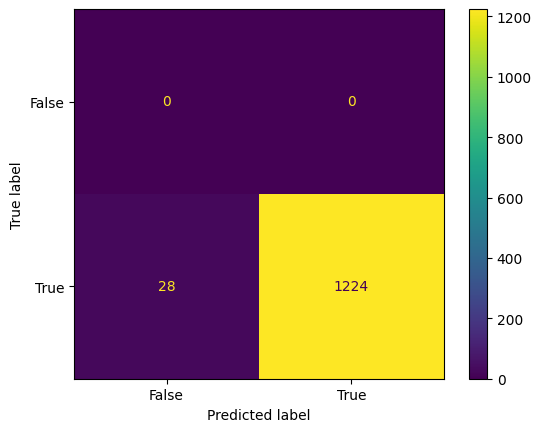

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(test_labels, pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
Accuracy = metrics.accuracy_score(test_labels, pred)
Precision = metrics.precision_score(test_labels, pred)
Sensitivity_recall = metrics.recall_score(test_labels, pred)
Specificity = metrics.recall_score(test_labels, pred, pos_label=0)
F1_score = metrics.f1_score(test_labels, pred)

#metrics
print("Accuracy : ",Accuracy)
print("Precision : ",Precision)
print("Sensitivity_recall : ",Sensitivity_recall)
print("Specificity : ",Specificity)
print("F1_score",F1_score)
print("\n\n\n")

Accuracy :  0.9776357827476039
Precision :  1.0
Sensitivity_recall :  0.9776357827476039
Specificity :  0.0
F1_score 0.9886914378029079






/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
